# Electricity Demand Forecasting

### 1. Import Modules

In [1]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

#from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

### 2. Read Data File

In [2]:
data_file = '../data/big_demand_temp.csv'

In [12]:
full_df = pd.read_csv(data_file)
full_df.head()

,Unnamed: 0,Unnamed: 0.1,time,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop
0,0,0,2020-03-09 14:00:00+00:00,29084,50.35,52.32,46.07,50.84,50.37,47.14,14261874.0
1,1,1,2020-03-09 13:00:00+00:00,26088,49.10,51.98,46.51,51.19,50.34,47.62,14261874.0
2,2,2,2020-03-09 12:00:00+00:00,24525,49.21,52.82,46.00,51.63,50.41,48.89,14261874.0
3,3,3,2020-03-09 11:00:00+00:00,23785,49.88,52.97,46.72,51.79,50.88,50.79,14261874.0
4,4,4,2020-03-09 10:00:00+00:00,23759,49.79,53.72,47.47,51.70,51.80,51.45,14261874.0


In [13]:
# Drop the old index column that pandas adds for us
full_df.drop('Unnamed: 0', axis=1, inplace=True)
full_df.drop('Unnamed: 0.1', axis=1, inplace=True)

# Convert the time string to a datetime object
dt_time = [parser.isoparse(x) for x in full_df.loc[:, 'time']]
full_df.index = pd.DatetimeIndex(dt_time)
full_df.drop('time', axis=1, inplace=True)
full_df.sort_index(inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41114 entries, 2015-07-01 08:00:00+00:00 to 2020-03-09 14:00:00+00:00
Data columns (total 8 columns):
demand           41114 non-null int64
Los Angeles      41114 non-null float64
San Diego        41114 non-null float64
San Jose         41114 non-null float64
San Francisco    41114 non-null float64
Sacramento       41114 non-null float64
Fresno           41114 non-null float64
CA_pop           41114 non-null float64
dtypes: float64(7), int64(1)
memory usage: 2.8 MB


In [14]:
full_df.head()

,demand,Los Angeles,San Diego,San Jose,San Francisco,Sacramento,Fresno,CA_pop
2015-07-01 08:00:00+00:00,38210,71.60,68.76,70.89,59.32,79.80,86.04,13845790.0
2015-07-01 09:00:00+00:00,35171,70.93,68.19,69.78,58.96,77.77,86.35,13845790.0
2015-07-01 10:00:00+00:00,33243,70.43,68.29,68.07,58.63,76.51,82.74,13845790.0
2015-07-01 11:00:00+00:00,31955,70.87,68.32,66.92,58.11,74.94,82.04,13845790.0
2015-07-01 12:00:00+00:00,31199,71.58,68.46,66.16,57.90,73.80,80.37,13845790.0


In [15]:
# Split the data into training and test sections
data_len = full_df.shape[0]


In [16]:
test_len = int(0.5 * data_len)

In [17]:
X_train = full_df.iloc[:test_len, :]
X_test = full_df.iloc[test_len:, :]

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20557 entries, 2015-07-01 08:00:00+00:00 to 2017-11-03 20:00:00+00:00
Data columns (total 8 columns):
demand           20557 non-null int64
Los Angeles      20557 non-null float64
San Diego        20557 non-null float64
San Jose         20557 non-null float64
San Francisco    20557 non-null float64
Sacramento       20557 non-null float64
Fresno           20557 non-null float64
CA_pop           20557 non-null float64
dtypes: float64(7), int64(1)
memory usage: 1.4 MB


In [23]:
def build_demand (residual_data) :
    running_demand = 0
    demand_list = np.zeros(len(residual_data))
    for i, val in enumerate(residual_data) :
        running_demand += val
        demand_list[i] = running_demand
        
    return demand_list
    

In [24]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

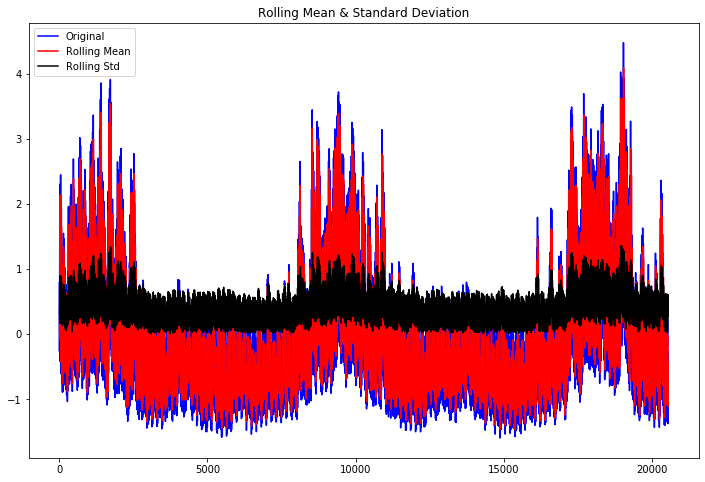

Results of Dickey-Fuller Test:
p-value = 0.0008. The series is likely stationary.
Test Statistic                    -4.142402
p-value                            0.000823
#Lags Used                        20.000000
Number of Observations Used    20536.000000
Critical Value (1%)               -3.430668
Critical Value (5%)               -2.861681
Critical Value (10%)              -2.566845
dtype: float64


In [25]:
test_stationarity(demand_data_norm.demand, window=8)

In [111]:
decomp_data = seasonal_decompose(X_train.demand, period=24, model='multiplicative')

In [112]:
decomp_data

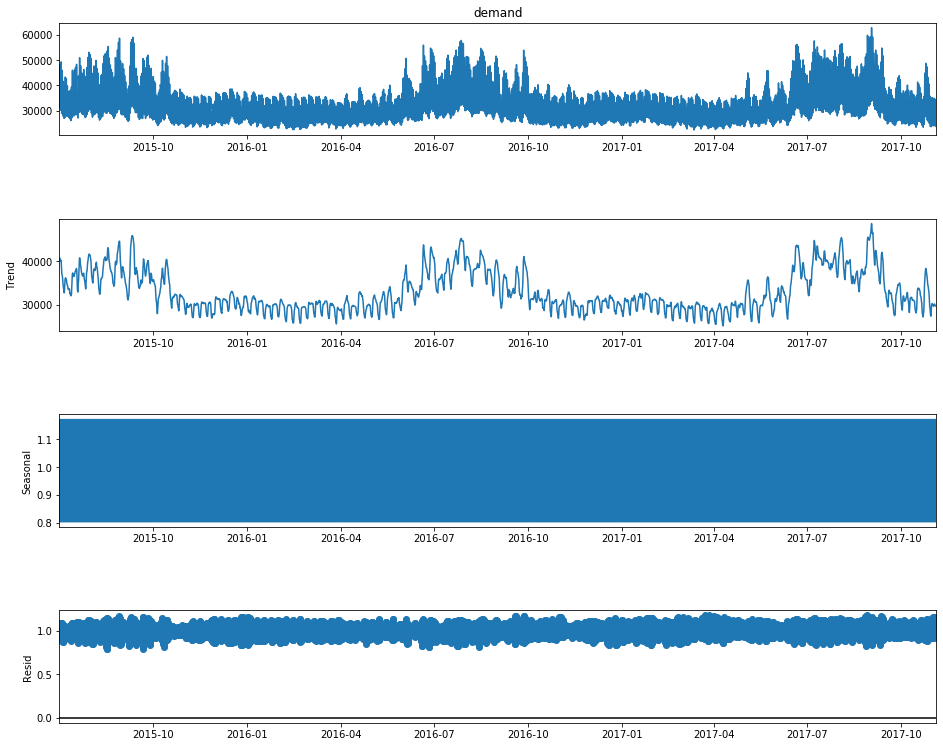

In [113]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

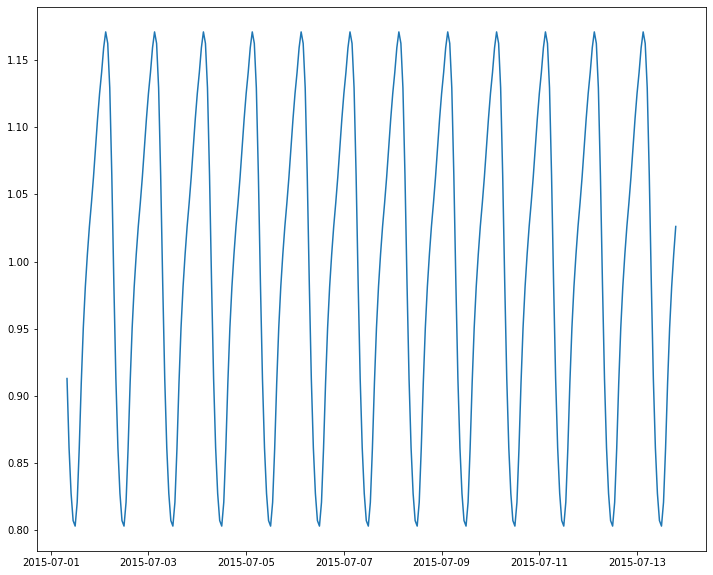

In [114]:
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.seasonal[:300])

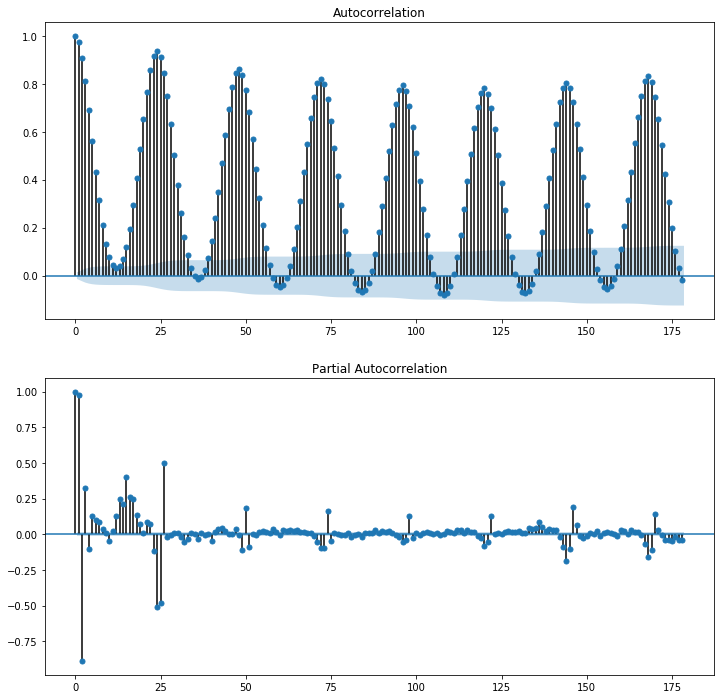

In [115]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(demand_data_norm['demand'], lags=24*7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(demand_data_norm['demand'], lags=24*7+10, ax=ax2)# , lags=40

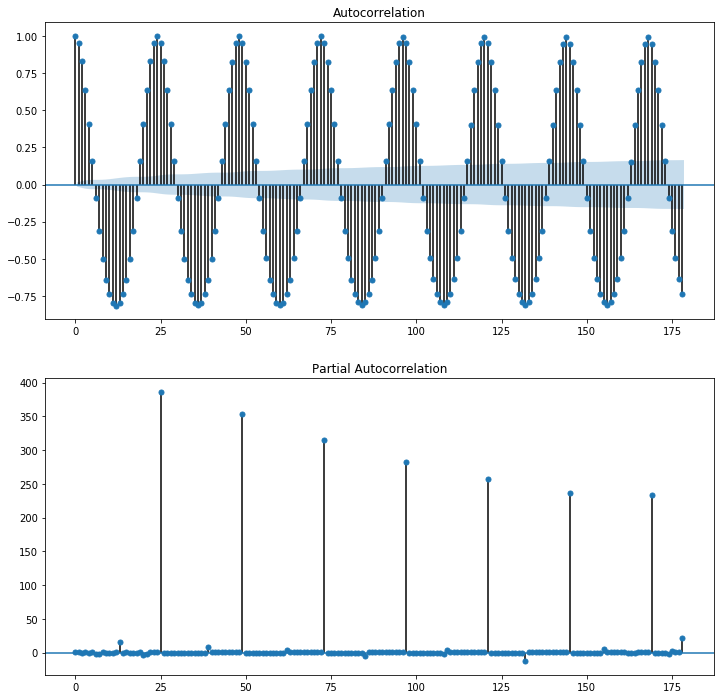

In [116]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(decomp_data.seasonal, lags=24*7+10, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(decomp_data.seasonal, lags=24*7+10, ax=ax2)

In [88]:
city_temps = X_train.columns[1:]

In [108]:
#seasonal_model1 = SARIMAX(decomp_data.seasonal, exog=demand_data_norm[city_temps].values,\
#    order=(15,1,0), simple_differencing=True, seasonal_order=(1, 1, 0, 24))
#seasonal_model1 = SARIMAX(decomp_data.seasonal, simple_differencing=True, \
#    order=(5, 0, 0), seasonal_order=(2,0,0,24))
model = ARIMA(decomp_data.seasonal, order=(1, 0, 0))
res = model.fit()
print(res.summary())

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:               seasonal   No. Observations:                20557
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -175128.904
Date:                Thu, 12 Mar 2020   AIC                         350263.808
Time:                        15:05:16   BIC                         350287.601
Sample:                    07-01-2015   HQIC                        350271.582
                         - 11-03-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9944    329.545     -0.006      0.995    -647.891     643.903
ar.L1          0.9572      0.003    338.013      0.000       0.952       0.963
sigma2      1.469e+06   3.01e+04     48.751      0.0

In [109]:
res

In [110]:
fig = plt.figure(figsize=[12, 8])
plt.plot(res.resid[:200])
plt.plot(decomp_data.seasonal.values[:200])

ValueError: view limit minimum -36789.43125 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

## actual

In [232]:
res.resid

array([ 0.89937194, -2.26815878,  1.77510326, ..., -0.0208139 ,
       -0.00370273, -0.02598136])

In [233]:
demand_scale

array([6474.01778079])